In [1]:
from scipy.io import arff
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Import Dataset

#### Important Note!!
Dataset file, myst be in the same directory with Jupyter Notebook file.

In [2]:
current_working_directory = os.getcwd()
dataset_file_name = "\\data\\kc1.arff"

data = arff.loadarff(current_working_directory + dataset_file_name)
df = pd.DataFrame(data[0])
df

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,b'false'
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,b'true'
2,83.0,11.0,1.0,11.0,171.0,927.89,0.04,23.04,40.27,21378.61,...,65.0,10.0,6.0,0.0,18.0,25.0,107.0,64.0,21.0,b'true'
3,46.0,8.0,6.0,8.0,141.0,769.78,0.07,14.86,51.81,11436.73,...,37.0,2.0,5.0,0.0,16.0,28.0,89.0,52.0,15.0,b'true'
4,25.0,3.0,1.0,3.0,58.0,254.75,0.11,9.35,27.25,2381.95,...,21.0,0.0,2.0,0.0,11.0,10.0,41.0,17.0,5.0,b'true'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,19.0,2.0,1.0,2.0,40.0,175.69,0.15,6.82,25.77,1197.90,...,12.0,1.0,2.0,0.0,10.0,11.0,25.0,15.0,3.0,b'false'
2105,23.0,3.0,3.0,3.0,60.0,278.63,0.10,9.69,28.75,2700.58,...,18.0,1.0,2.0,0.0,12.0,13.0,39.0,21.0,5.0,b'false'
2106,2.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,...,0.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,1.0,b'false'
2107,13.0,1.0,1.0,1.0,17.0,60.94,0.25,4.00,15.24,243.78,...,6.0,0.0,5.0,0.0,6.0,6.0,9.0,8.0,1.0,b'false'


# 2. Overview 

#### 2.1 Description
<ins>KC1 Software defect prediction:</ins> <br>
One of the NASA Metrics Data Program defect data sets. Data from software for storage management to download and process terrain data. The data comes from the McCabe and Halstead source code feature exporters. These characteristics were defined in the 1970s in an attempt to objectively characterize code characteristics related to software quality.

This data is used to train classifiers in order to recognize whether a module has defects or not. Module is the smallest unit of functionality. In C or Smalltalk, modules would be called "function" or "method" respectively.

#### 2.2 Attribute Information
Our data consists of 2109 data samples where each sample contains 22 features of which 5 different metrics for lines of code, 3 McCabe metrics, 4 base Halstead metrics, 8 derived Halstead metrics, a branch-count , and 1 category. The features are as follows:
1. loc: numeric % McCabe's line count of code
2. v(g): numeric % McCabe "cyclomatic complexity"
3. ev(g): numeric % McCabe "essential complexity"
4. iv(g): numeric % McCabe "design complexity"
5. n: numeric % Halstead total operators + operands
6. v: numeric % Halstead "volume"
7. l: numeric % Halstead "program length"
8. d: numeric % Halstead "difficulty"
9. i: numeric % Halstead "intelligence"
10. e: numeric % Halstead "effort"
11. b: numeric % Halstead 
12. t: numeric % Halstead's time estimator
13. lOCode: numeric % Halstead's line count
14. lOComment: numeric % Halstead's count of lines of comments
15. lOBlank: numeric % Halstead's count of blank lines
16. lOCodeAndComment: numeric
17. uniq_Op: numeric % unique operators
18. uniq_Opnd: numeric % unique operands
19. total_Op: numeric % total operators
20. total_Opnd: numeric % total operands
21. branchCount: numeric % of the flow graph
22. problems: {false,true}% module has/has not one or more reported defects

All attributes have numeric values except the last attribute called defects which takes the values "btrue" and "bfalse". This last feature also constitutes the labels of the samples.

In [3]:
print("Number of data samples: {}\nNumber of features: {}".format(df.shape[0], df.shape[1]))

Number of data samples: 2109
Number of features: 22


Also from the description of our data we know that there are no missing values.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                2109 non-null   float64
 1   v(g)               2109 non-null   float64
 2   ev(g)              2109 non-null   float64
 3   iv(g)              2109 non-null   float64
 4   n                  2109 non-null   float64
 5   v                  2109 non-null   float64
 6   l                  2109 non-null   float64
 7   d                  2109 non-null   float64
 8   i                  2109 non-null   float64
 9   e                  2109 non-null   float64
 10  b                  2109 non-null   float64
 11  t                  2109 non-null   float64
 12  lOCode             2109 non-null   float64
 13  lOComment          2109 non-null   float64
 14  lOBlank            2109 non-null   float64
 15  locCodeAndComment  2109 non-null   float64
 16  uniq_Op            2109 

#### 2.3 Class Distribution

It is very important to check if our data set is balanced.<br>
We observe that it is not, as there are 1783 samples of the b'false' class corresponding to 84.54% of the total dataset, while there are only 326 samples of the b'true' class corresponding to 15.45% of the total dataset.

In [5]:
for label in [b'false', b'true']:
    number_of_samples = sum(df["defects"] == label)
    print("For class: {}\n\tNumber of data samples: {}\n\tPercentage of dataset: {}%".format(label, number_of_samples, number_of_samples*100/df.shape[0]))

For class: b'false'
	Number of data samples: 1783
	Percentage of dataset: 84.54243717401611%
For class: b'true'
	Number of data samples: 326
	Percentage of dataset: 15.457562825983878%


# 3. Preprocesing

#### 3.1 Convert Categorical Variables

First, it is very important to convert the **defects** feature, which is also the label of the sample, to an integer so that the machine learning algorithms can handle it.<br>
This attribute takes the values {b'false', b'true'}.<br>
We will convert it so that 0 represents the value b'false' and 1 represents the value b'true'.

In [6]:
# Replace value b'false' with 0, and value b'true' with 1.
df["defects"] = np.where(df["defects"] == b'false', 0, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2109 entries, 0 to 2108
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   loc                2109 non-null   float64
 1   v(g)               2109 non-null   float64
 2   ev(g)              2109 non-null   float64
 3   iv(g)              2109 non-null   float64
 4   n                  2109 non-null   float64
 5   v                  2109 non-null   float64
 6   l                  2109 non-null   float64
 7   d                  2109 non-null   float64
 8   i                  2109 non-null   float64
 9   e                  2109 non-null   float64
 10  b                  2109 non-null   float64
 11  t                  2109 non-null   float64
 12  lOCode             2109 non-null   float64
 13  lOComment          2109 non-null   float64
 14  lOBlank            2109 non-null   float64
 15  locCodeAndComment  2109 non-null   float64
 16  uniq_Op            2109 

Now our data has the following form.

In [8]:
df

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,...,2.0,2.0,2.0,2.0,1.2,1.2,1.2,1.2,1.4,0
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1
2,83.0,11.0,1.0,11.0,171.0,927.89,0.04,23.04,40.27,21378.61,...,65.0,10.0,6.0,0.0,18.0,25.0,107.0,64.0,21.0,1
3,46.0,8.0,6.0,8.0,141.0,769.78,0.07,14.86,51.81,11436.73,...,37.0,2.0,5.0,0.0,16.0,28.0,89.0,52.0,15.0,1
4,25.0,3.0,1.0,3.0,58.0,254.75,0.11,9.35,27.25,2381.95,...,21.0,0.0,2.0,0.0,11.0,10.0,41.0,17.0,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2104,19.0,2.0,1.0,2.0,40.0,175.69,0.15,6.82,25.77,1197.90,...,12.0,1.0,2.0,0.0,10.0,11.0,25.0,15.0,3.0,0
2105,23.0,3.0,3.0,3.0,60.0,278.63,0.10,9.69,28.75,2700.58,...,18.0,1.0,2.0,0.0,12.0,13.0,39.0,21.0,5.0,0
2106,2.0,1.0,1.0,1.0,4.0,8.00,0.67,1.50,5.33,12.00,...,0.0,0.0,0.0,0.0,3.0,1.0,3.0,1.0,1.0,0
2107,13.0,1.0,1.0,1.0,17.0,60.94,0.25,4.00,15.24,243.78,...,6.0,0.0,5.0,0.0,6.0,6.0,9.0,8.0,1.0,0


#### 3.2 Separation of Dataset

Next we will split the dataset into 2 sub-sets.<br>
We will have the training set (Train Dataset), with which we will train (Training Stage) the machine learning algorithms that we will use later, and the control set (Test Dataset) with which we will evaluate them (Evaluation Stage).

In [9]:
# Store the names of all the features.
feature_names_lst = list(df.columns)[:-1]
# Store the name of the class.
class_name = list(df.columns)[-1]

In [10]:
# Split data to training and test set. Test set is 30% of total data.
# shuffle = True: shuffle the data before splitting.
X_train, X_test, y_train, y_test = train_test_split(df[feature_names_lst], df[class_name], test_size =0.3, shuffle = True)

In [11]:
# Convert dataframes to numpy arrays.
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

In [12]:
print("Number of train samples: {}\nNumber of test samples: {}".format(X_train_np.shape[0], X_test_np.shape[0]))

Number of train samples: 1476
Number of test samples: 633


#### Therefore, the training dataset consists of 1476 samples while the test dataset consists of 633 samples.

# 4. Training without optimization (Out of the box)

First we will see how the classifiers behave without any optimization (out-of-the-box) and with all parameters at default values.<br>
So we will train all classifiers with a simple fit on the entire training set and calculate their performance on the test set using two metrics, Accuracy and F1-Score.

#### 4.1 Dummy Classifier

Dummy Classifier makes predictions that ignore the input features.<br>
In the predict method, the default argument is "prior", which always returns the most frequent class label from y_test.

In [13]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train_np, y_train_np)
y_predictions_dummy = dummy_clf.predict(X_test_np)
accuracy_dummy = dummy_clf.score(X_test_np, y_test_np)
f1_score_dummy = f1_score(y_test_np, y_predictions_dummy, average = 'macro')

print("Dummy Classifier:\n\tAccuracy Score: {}\n\tF1-Score: {}".format(accuracy_dummy, f1_score_dummy))

Dummy Classifier:
	Accuracy Score: 0.8388625592417062
	F1-Score: 0.4561855670103093


#### 4.2 Gaussian Naive Bayes Classifier

The Gaussian Naive Bayes Classifier classifies the data into the class with the highest posterior probability, assuming independence between the features of each sample.

In [14]:
gaussian_clf = GaussianNB()
gaussian_clf.fit(X_train_np, y_train_np)
y_predictions_gaussian = gaussian_clf.predict(X_test_np)
accuracy_gaussian = gaussian_clf.score(X_test_np, y_test_np)
f1_score_gaussian = f1_score(y_test_np, y_predictions_gaussian, average = 'macro')

print("Gaussian Naive Bayes Classifier:\n\tAccuracy Score: {}\n\tF1-Score: {}".format(accuracy_gaussian, f1_score_gaussian))

Gaussian Naive Bayes Classifier:
	Accuracy Score: 0.8183254344391785
	F1-Score: 0.654333239946247


#### 4.3 k-Nearest Neighbor Classifier

k-NN for each sample, finds k nearest neighbors and the class of the sample is the majority among the k neighbors.<br>
Here the default value for k is 5. An odd number is usually chosen so that there is no case of equality.

In [15]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_np, y_train_np)
y_predictions_knn = knn_clf.predict(X_test_np)
accuracy_knn = knn_clf.score(X_test_np, y_test_np)
f1_score_knn = f1_score(y_test_np, y_predictions_knn, average = 'macro')

print("k-Nearest Neighbor Classifier:\n\tAccuracy Score: {}\n\tF1-Score: {}".format(accuracy_knn, f1_score_knn))

k-Nearest Neighbor Classifier:
	Accuracy Score: 0.8104265402843602
	F1-Score: 0.5840087623220154


#### Logistic Regression Classifier

Logistic Regression is a machine learning classification algorithm used to predict the probability of certain classes based on certain dependent variables. In short, the logistic regression model estimates a sum of input characteristics and calculates its logistic output. The output of logistic regression is always between (0, and 1), which is suitable for a binary classification task. The higher the value, the higher the probability that the current sample is classified as class=1 and vice versa.

In [16]:
logistic_regression_clf = LogisticRegression()
logistic_regression_clf.fit(X_train_np, y_train_np)
y_predictions_lr = logistic_regression_clf.predict(X_test_np)
accuracy_lr = logistic_regression_clf.score(X_test_np, y_test_np)
f1_score_lr = f1_score(y_test_np, y_predictions_lr, average = 'macro')

print("Logistic Regression Classifier:\n\tAccuracy Score: {}\n\tF1-Score: {}".format(accuracy_lr, f1_score_lr))

Logistic Regression Classifier:
	Accuracy Score: 0.8246445497630331
	F1-Score: 0.5778301178251908


#### 4.5 MLP Classifier

The MLP Classifier has the following default parameters:
- ReLu as activation function
- learning rate = 0.001
- optimizer = adam

In [17]:
mlp_clf = MLPClassifier()
mlp_clf.fit(X_train_np, y_train_np)
y_predictions_mlp = mlp_clf.predict(X_test_np)
accuracy_mlp = mlp_clf.score(X_test_np, y_test_np)
f1_score_mlp = f1_score(y_test_np, y_predictions_mlp, average = 'macro')

print("MLP Classifier:\n\tAccuracy Score: {}\n\tF1-Score: {}".format(accuracy_mlp, f1_score_mlp))

MLP Classifier:
	Accuracy Score: 0.8372827804107424
	F1-Score: 0.45571797076526227


#### 4.6 SVM Classifier

In [18]:
svm_clf = SVC()
svm_clf.fit(X_train_np, y_train_np)
y_predictions_svm = svm_clf.predict(X_test_np)
accuracy_svm = svm_clf.score(X_test_np, y_test_np)
f1_score_svm = f1_score(y_test_np, y_predictions_svm, average = 'macro')

print("SVM Classifier:\n\tAccuracy Score: {}\n\tF1-Score: {}".format(accuracy_svm, f1_score_svm))

SVM Classifier:
	Accuracy Score: 0.8388625592417062
	F1-Score: 0.5627979414951246


#### 4.7 Results

##### 4.7.1 Metrics

To evaluate the classifiers we use 2 metrics: Accuracy and F1-score.

**Accuracy:**<br>
It is the total number of correct predictions divided by the total number of predictions made for a data set. Accuracy is useful and representative when my data is balanced.

**F1-score:**<br>
The F1-score tells you how precise the model is, i.e. how many samples it classifies correctly, and how robust it is, i.e. that it doesn't miss a significant number of samples when you check it on the control set. The F1-score is representative, even when my data is unbalanced.

##### 4.7.2.1 Classifier Results in a Data Frame

In [19]:
accuracy_lst = [accuracy_dummy, accuracy_gaussian, accuracy_knn, accuracy_lr, accuracy_mlp, accuracy_svm]
f1_score_lst = [f1_score_dummy, f1_score_gaussian, f1_score_knn, f1_score_lr, f1_score_mlp, f1_score_svm]
classifier_names_lst = ["Dummy", "Gaussian Naive Bayes", "K-NN", "Logistic Regression", "MLP", "SVM"]

out_of_the_box_results_dict = {
    'Acuracy': accuracy_lst,
    'F1-Score': f1_score_lst
}
  
# Creates pandas DataFrame.
out_of_the_box_results_df = pd.DataFrame(out_of_the_box_results_dict, index = classifier_names_lst)
out_of_the_box_results_df

,Acuracy,F1-Score
Dummy,0.838863,0.456186
Gaussian Naive Bayes,0.818325,0.654333
K-NN,0.810427,0.584009
Logistic Regression,0.824645,0.577830
MLP,0.837283,0.455718
SVM,0.838863,0.562798


##### 4.7.3 Comparison of Results using Bar Plot

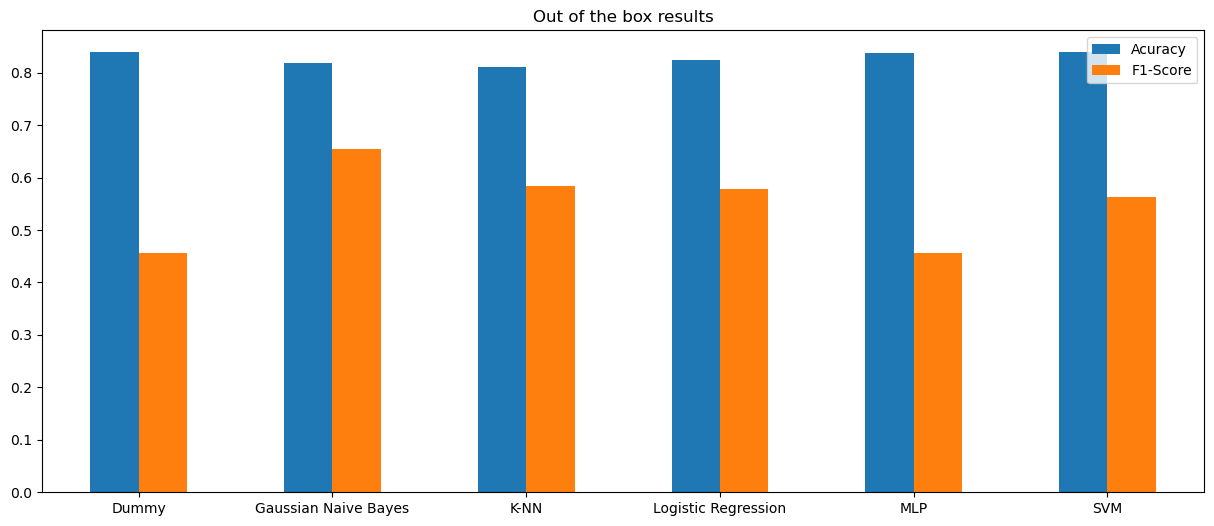

In [20]:
ax = out_of_the_box_results_df.plot.bar(rot = 0, title = "Out of the box results", figsize = (15, 6))

##### 4.7.4 Remarks

- We notice that in each classifier the accuracy is much higher than the f1-score. This is because the data set we are considering is not balanced. As we mentioned in section 2.3, 84% of the dataset is b'false', while only 16% of the dataset is b'true'. So it is very likely that our classifiers are not learning well to recognize data belonging to the b'true' class.
- Due to the previous remarks, a better evaluation will result if we compare the algorithms with the f1-score, which has representative results even if the data set is not balanced.
- The reason why the Dummy Classifier has high Accuracy is because it always returns the most frequent class label, and because the particular data set is unbalanced, it has high Accuracy. On the contrary, compared to the rest of the classifiers, it has the lowest F1-score, which is reasonable.
- If we exclude the dummy Classifier (for the reasons mentioned above), then the classifier with the best performance is the Gaussian Naive Bayes Classifier with f1-score = 65%


# 5. Training with Optimization Methods


In many classification problems (and machine learning in general) preprocessing is a very important (and often very time-consuming) part of the whole process, but it often has a very large impact on system performance.

Preprocessing steps aim to:
* To remove or replace missing values from the dataset
* In converting categorical variables appropriately so that they can be handled by machine learning algorithms
* In selecting or extracting the appropriate features for our model

**Our data set has no missing values and no categorical features at all.**

### 5.1 Explanation of some preprocessing techniques

A very important parameter for the performance of classifiers is the dimensionality of the data, especially with respect to the number of samples available. In general and regardless of the classifier model, performance increases as the quantity and quality of the data increases and as the dimensionality decreases. Conversely, problems become more difficult as the dimensionality increases and the samples are not sufficient to cover all classes of the problem.

There are various **dimensionality reduction** techniques. Two techniques are as follows:<br>
* **Feature selection:**<br>
We remove some features based on a criterion without transforming their values.<br>
* **Feature extraction:**<br>
We transform the attribute values into new ones (that is, we extract new attributes) but in a space of smaller dimensions.

#### 5.1.1 Feature Selection
A simple feature selection technique is the **Variance threshold**. If the variance of an input feature is too low, it cannot contribute significantly to the discriminative ability of the classifier. Especially in the case that the variance is 0, i.e. the feature has a fixed value for all training samples, it is of no use to the classifier to decide whether a sample belongs to one class or another, and in addition it can complicate other preprocessing procedures such as the normalization of features. We can use the VarianceThreshold function to remove features in the training set that have zero (default) or very low variance.

In [21]:
# The variance of every feature.
print("Variance of every feature:\n{}\n".format(df[feature_names_lst].var()))
print("Variance statistics:\n{}".format(df[feature_names_lst].var().describe()))


Variance of every feature:
loc                  8.853268e+02
v(g)                 1.521595e+01
ev(g)                4.842900e+00
iv(g)                1.139643e+01
n                    6.988939e+03
v                    2.665839e+05
l                    1.005074e-01
d                    6.183692e+01
i                    4.622658e+02
e                    3.043274e+08
b                    3.080254e-02
t                    9.392811e+05
lOCode               5.850740e+02
lOComment            9.518898e+00
lOBlank              1.487529e+01
locCodeAndComment    4.956480e-01
uniq_Op              3.283687e+01
uniq_Opnd            1.487357e+02
total_Op             2.680760e+03
total_Opnd           1.028767e+03
branchCount          6.071848e+01
dtype: float64

Variance statistics:
count    2.100000e+01
mean     1.454982e+07
std      6.639671e+07
min      3.080254e-02
25%      1.139643e+01
50%      6.183692e+01
75%      1.028767e+03
max      3.043274e+08
dtype: float64


From the above results, we notice that no feature in this dataset has a variance equal to 0.<br>
We also notice that the smallest variance has the feature with **b** with a value of **3.080254e-02**, while the next smallest has the feature **l** with a value of **1.005074e-01* * and then **locCodeAndComment** with value **4.956480e-01**

#### 5.1.2 Normalization

Features with very large differences in their absolute values can cause problems in training and yield classifiers with suboptimal performance.<br>

The normalization of the features can be done in 2 basic ways, also known from statistics:
* By dividing by the maximum-minimum difference (feature scaling) so the
values of all attributes scale linearly in the interval [0,1]
* or with the z-score (or standard score) of each characteristic (standardization), which makes the characteristic have a mean value of zero and a variance of one, like the normal distribution.

Conversion to standard score is necessary in many classifiers to behave correctly. It is also more resistant than min-max to outlier values, i.e. sporadic values that are very far from the average value and the rest of the characteristic values (min-max will compress most values into a small interval).<br>
On the other hand, scaling to [0,1] is less sensitive to very small deviations and also in sparse feature vectors (i.e. with many zero values) its application preserves the zeros, which can be decisive for training speed.

#### 5.1.3 Balanced Dataset

As we have shown above, our data is unbalanced. More specifically, we have a total of 2109 samples of which 1783 (85%) belong to one category and the remaining 326 (15%) belong to the other category.

It is known that most classifiers are however trained best when the samples of all classes are relatively equal.

There are two basic ways to make a dataset balanced, undersampling and oversampling.<br>
**Undersampling:**<br>
We randomly remove samples from all categories that have a larger number than the smallest<br>
**Oversampling:**<br>
We randomly select some examples from the less frequent categories and repeat them.

Generally oversampling is more recommended as we don't lose data.

It is also important to note that we do not perform any sampling operation on the test set.

In [22]:
!pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


#### 5.1.4 Feature Extraction

As we said before, feature extraction is the technique in which we transform the values of the features into new ones (that is, we extract new features) but in a space of smaller dimensions.

The most well-known technique is PCA.

### 5.2 Grid search

An ML procedure consists of a series of transformations on the features of the data ending in an estimator.

Transformers are used to pre-process (through transformation) the data.

Transformers in general also have hyper-parameters that affect their operation.

A trained model estimator (classifier) is composed
- a) from its architecture, i.e. the combination of transformers and the choice of the final estimator (the pipeline), and
- b) from the (optimal) values of the hyper-parameters of all the previous ones resulting from the cross-validation.

The rendering of all possible combinations of transformer hyper-parameters and estimator is done by grid search.

In [23]:
!pip install -U imbalanced-learn

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


We initialize the transformers without hyper-parameters.

In [24]:
# Init the transformers without hyperparameters.
selector = VarianceThreshold()
scaler = StandardScaler()
ros = RandomOverSampler()
pca = PCA()

First we study the variance of the variables for the variance threshold. Since we do not have variance=0, we will give the variance threshold as an argument the 4 smallest variance values that our data has.

In [25]:
x_train_variances = X_train_np.var(axis = 0) # Find the variance of every feature.
print("Variance of every feature:\n{}".format(x_train_variances))
sorted_x_train_variances = np.sort(x_train_variances)
# Create a list with the 4 minimum variances.
variance_thresholds_lst = [sorted_x_train_variances[0], sorted_x_train_variances[1],sorted_x_train_variances[2],sorted_x_train_variances[3]]

number_of_folds = 10

Variance of every feature:
[7.91285660e+02 1.40906000e+01 4.68661135e+00 1.02043959e+01
 6.65279561e+03 2.55344076e+05 1.00073577e-01 5.92571167e+01
 4.42235883e+02 2.96651300e+08 2.90375729e-02 9.15589738e+05
 5.23057757e+02 8.19867473e+00 1.44606876e+01 4.54309604e-01
 3.16455313e+01 1.44269615e+02 2.52541582e+03 9.94660264e+02
 5.62130800e+01]


GridSearchCV does cross-validation and grid search together.

**memory = 'tmp'**<br>
For each fold of the crossvalidation and for each combination of transform hyperparameters, the data need to be transformed once and not for each new estimator hyperparameter value.

**Our data consists of 2109 samples with 22 features each. Regarding the dimension of the samples, the number of data could be considered quite satisfactory. So we will examine the classifiers once applying the pca technique and once without applying it.**

### 5.2.1 Χρήση PCA

**Since we will use the pca technique, it is good to first check the importance of each principal component in our data. For this reason we will check the explained variance of the principal components. Explained variance is a statistical measure of how much variation in a data set can be attributed to each of the principal components (eigenvectors) generated by the PCA method. In general, it refers to the amount of variability in a data set that can be attributed to each individual principal component. That is, it tells us how much of the total variance is "explained" by each component. This is important because it allows us to rank items in order of importance and focus on the most important when interpreting the results of our analysis.**

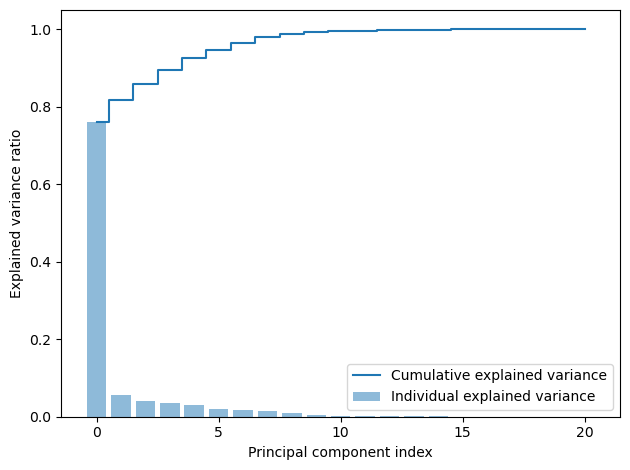

In [27]:
# Scale the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(X_train_np)
X_train_std = sc.transform(X_train_np)
X_test_std = sc.transform(X_test_np)

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance.
exp_var_pca = pca.explained_variance_ratio_

# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**From the above graph we notice that with 0 principal components we describe 78% of our data, with 1 principal component we describe 81% of our data, with 2 principal components a little more and so on. It is worth noting that after 7 to 8 principal components there is no significant increase. So we'll try for prices until then.**

In [28]:
pca_n_components_lst = [1, 2, 3, 4, 5, 6, 7, 8]

In [29]:
dummy_clf_strategy_lst = ["most_frequent", "prior", "stratified", "uniform"]
dummy_clf = DummyClassifier()
dummy_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('dummy', dummy_clf)], memory = 'tmp')
dummy_estimator = GridSearchCV(dummy_pipe, dict(selector__threshold = variance_thresholds_lst, pca__n_components = pca_n_components_lst, dummy__strategy = dummy_clf_strategy_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

gaussian_clf = GaussianNB() 
gaussian_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('gaussian', gaussian_clf)], memory = 'tmp')
gaussian_estimator = GridSearchCV(gaussian_pipe, dict(selector__threshold = variance_thresholds_lst, pca__n_components = pca_n_components_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

k_number_of_neighbors_lst = [1, 2, 3, 5, 7, 9, 11]
knn_clf = KNeighborsClassifier(n_jobs = -1) # n_jobs = -1: uses all the cores of the cpu.
knn_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('kNN', knn_clf)], memory = 'tmp')
knn_estimator = GridSearchCV(knn_pipe, dict(selector__threshold = variance_thresholds_lst, pca__n_components = pca_n_components_lst, kNN__n_neighbors = k_number_of_neighbors_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

lr_solver_lst = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
lr_max_iter_lst = [300,500,700]
lr_clf = LogisticRegression()
lr_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('lr', lr_clf)], memory = 'tmp')
lr_estimator = GridSearchCV(lr_pipe, dict(selector__threshold = variance_thresholds_lst, pca__n_components = pca_n_components_lst, lr__solver = lr_solver_lst, lr__max_iter = lr_max_iter_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

mlp_hidden_layer_sizes_lst = [(50,), (100,), (150,)]
#mlp_activation_fuction_lst = ['logistic', 'tanh', "relu"]
mlp_solver_lst = ['lbfgs', 'sgd', 'adam']
mlp_clf = MLPClassifier()
mlp_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('mlp', mlp_clf)], memory = 'tmp')
mlp_estimator = GridSearchCV(mlp_pipe, dict(selector__threshold = variance_thresholds_lst, pca__n_components = pca_n_components_lst, mlp__hidden_layer_sizes = mlp_hidden_layer_sizes_lst, mlp__solver = mlp_solver_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

svm_kernel_lst = ['linear', 'poly', 'rbf', 'sigmoid']
svm_clf = SVC()
svm_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('pca', pca), ('svm', svm_clf)], memory = 'tmp')
svm_estimator = GridSearchCV(svm_pipe, dict(selector__threshold = variance_thresholds_lst, pca__n_components = pca_n_components_lst, svm__kernel = svm_kernel_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

In [30]:
best_accuracy_lst = []
best_f1_score_lst = []
estimators_y_predictions_dict = {}
total_time_lst = []
intermediate_results_lst = []

def find_best_estimator(estimator, estimator_name):
    print("Estimator: {}\n".format(estimator_name))
    start_time = time.time()
    estimator.fit(X_train_np, y_train_np)
    y_predictions = estimator.predict(X_test_np)
    estimators_y_predictions_dict[estimator_name] = y_predictions
    print("Total time for fit and predict: %s seconds" % (time.time() - start_time))
    total_time_lst.append((time.time() - start_time))
    print("Best Estimator: \n{}\n".format(estimator.best_estimator_))
    print("Best Parameter: \n{}\n".format(estimator.best_params_))
    intermediate_results_lst.append(estimator.cv_results_)
    clf_report_dict = classification_report(y_test_np, y_predictions, output_dict = True)
    print("Accuracy: {}\nF1-Score: {}".format(clf_report_dict["accuracy"], clf_report_dict["macro avg"]["f1-score"]))
    best_accuracy_lst.append(clf_report_dict["accuracy"])
    best_f1_score_lst.append(clf_report_dict["macro avg"]["f1-score"])
    print("==============================================================================")

In [31]:
estimators_dict = {dummy_estimator: "Dummy", 
                   gaussian_estimator: "Gaussian Naive Bayes", 
                   knn_estimator: "K-NN", 
                   lr_estimator: "Logistic Regression", 
                   mlp_estimator: "MLP", 
                   svm_estimator: "SVM"}

for current_estimator in estimators_dict:
    find_best_estimator(current_estimator, estimators_dict[current_estimator])

Estimator: Dummy

Total time for fit and predict: 13.602088451385498 seconds
Best Estimator: 
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.45430960407165044)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=4)),
                ('dummy', DummyClassifier(strategy='uniform'))])

Best Parameter: 
{'dummy__strategy': 'uniform', 'pca__n_components': 4, 'selector__threshold': 0.45430960407165044}

Accuracy: 0.5134281200631912
F1-Score: 0.44306184012066363
Estimator: Gaussian Naive Bayes

Total time for fit and predict: 2.047985076904297 seconds
Best Estimator: 
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.45430960407165044)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('pca', PCA(n_components=6)), ('gaussian', GaussianNB())])

Best Parameter: 
{'pca__n_components': 6, 'selector__threshold': 0.4

##### 5.2.1.1.1 Classifier Results in a Data Frame

In [33]:
final_results_dict = {
    'After Opt Acuracy': best_accuracy_lst,
    'Accuracy Difference': np.array(best_accuracy_lst) - np.array(accuracy_lst),
    'After Opt F1-Score': best_f1_score_lst,
    'F1-Score Difference': np.array(best_f1_score_lst) - np.array(f1_score_lst),
    'Total Time': total_time_lst
}
  
# Creates pandas DataFrame.
final_results_df = pd.DataFrame(final_results_dict, index = classifier_names_lst)
final_results_df

,After Opt Acuracy,Accuracy Difference,After Opt F1-Score,F1-Score Difference,Total Time
Dummy,0.513428,-0.325434,0.443062,-0.013124,13.602088
Gaussian Naive Bayes,0.824645,0.006319,0.691332,0.036999,2.047985
K-NN,0.788310,-0.022117,0.668052,0.084043,58.629998
Logistic Regression,0.775671,-0.048973,0.662083,0.084253,41.183950
MLP,0.750395,-0.086888,0.635868,0.180150,1651.390055
SVM,0.777251,-0.061611,0.659736,0.096938,142.267289


##### 5.2.1.2 Comparison of Results using Bar Plot

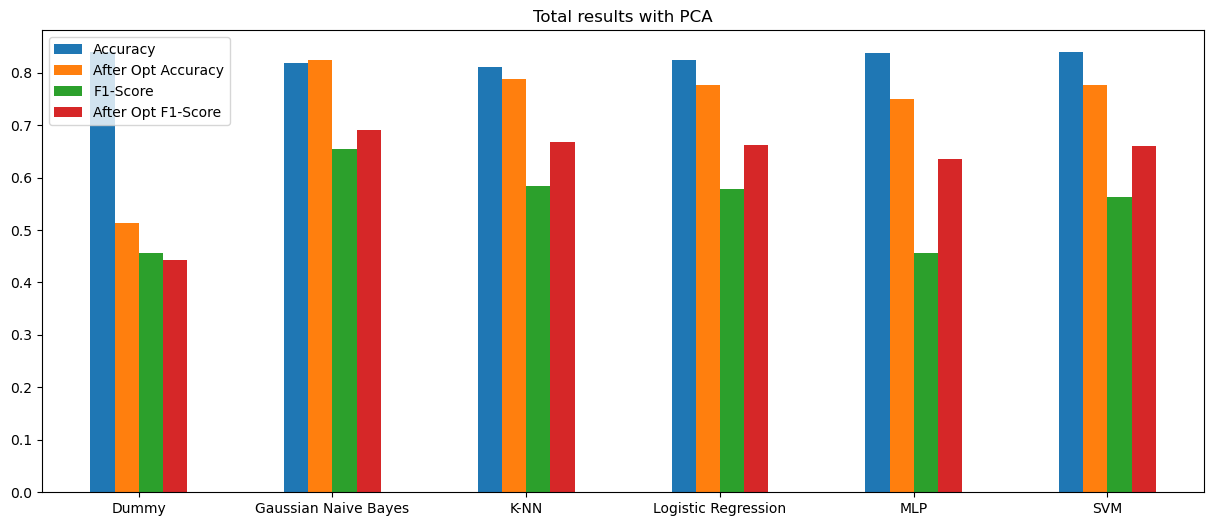

In [34]:
final_results_df = pd.DataFrame(
    {'Accuracy': accuracy_lst, 'After Opt Accuracy': best_accuracy_lst, 'F1-Score': f1_score_lst, 'After Opt F1-Score': best_f1_score_lst}, index = classifier_names_lst
)

ax = final_results_df.plot.bar(rot = 0, title = "Total results with PCA", figsize = (15, 6))

##### 5.2.1.3 Remarks

* We notice that the best performance based on the f1-score is the Gaussian Naive Bayes Classifier with a value of f1-score = 0.691332 and accuracy = 0.824645. The preprocessing parameters that gave it the best performance are {'pca__n_components': 6, 'selector__threshold': 0.03089166111257996} with a total time of 2.047985 seconds.

* The worst performance based on f1-score after the Dummy Classifier is MLP with a value of f1-score = 0.635868 and accuracy = 0.750395. The preprocessing parameters that led him to this performance are {'mlp__hidden_layer_sizes': (100,), 'mlp__solver': 'lbfgs', 'pca__n_components': 6, 'selector__threshold': 0.02903757293755187} with a total time of 1651.390055 seconds.

* We also notice that the Dummy Classifier has no improvement after preprocessing, which makes sense since it doesn't take samples into account at all.

* Apart from the dummy Classifier, all other Classifiers, after preprocessing have significantly improved their performance based on the F1-Score.

##### 5.2.1.5 Confusion Matrix

<AxesSubplot:>

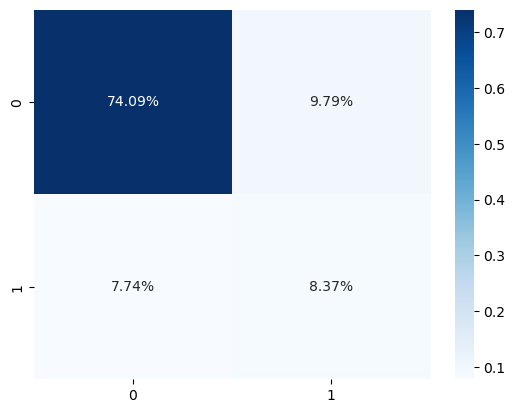

In [35]:
best_estimator_confusion_matrix = confusion_matrix(y_test_np, estimators_y_predictions_dict["Gaussian Naive Bayes"])
sns.heatmap(best_estimator_confusion_matrix/np.sum(best_estimator_confusion_matrix), 
            annot = True, 
            fmt = '.2%', 
            cmap = 'Blues'
           )

<AxesSubplot:>

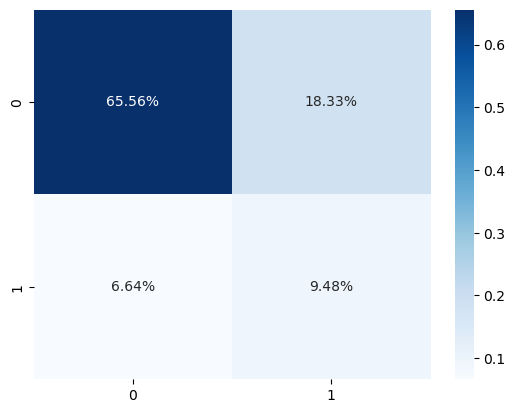

In [72]:
worst_estimator_confusion_matrix = confusion_matrix(y_test_np, estimators_y_predictions_dict["MLP"])
sns.heatmap(worst_estimator_confusion_matrix/np.sum(worst_estimator_confusion_matrix), 
            annot = True, 
            fmt = '.2%', 
            cmap = 'Blues'
           )

### 5.2.2 Without PCA

In [37]:
dummy_clf_strategy_lst = ["most_frequent", "prior", "stratified", "uniform"]
dummy_clf = DummyClassifier()
dummy_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('dummy', dummy_clf)], memory = 'tmp')
dummy_estimator = GridSearchCV(dummy_pipe, dict(selector__threshold = variance_thresholds_lst, dummy__strategy = dummy_clf_strategy_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

gaussian_clf = GaussianNB() 
gaussian_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('gaussian', gaussian_clf)], memory = 'tmp')
gaussian_estimator = GridSearchCV(gaussian_pipe, dict(selector__threshold = variance_thresholds_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

k_number_of_neighbors_lst = [1, 2, 3, 5, 7, 9, 11]
knn_clf = KNeighborsClassifier(n_jobs = -1) # n_jobs = -1: uses all the cores of the cpu.
knn_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('kNN', knn_clf)], memory = 'tmp')
knn_estimator = GridSearchCV(knn_pipe, dict(selector__threshold = variance_thresholds_lst, kNN__n_neighbors = k_number_of_neighbors_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

lr_solver_lst = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
lr_max_iter_lst = [300,500,700]
lr_clf = LogisticRegression()
lr_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('lr', lr_clf)], memory = 'tmp')
lr_estimator = GridSearchCV(lr_pipe, dict(selector__threshold = variance_thresholds_lst, lr__solver = lr_solver_lst, lr__max_iter = lr_max_iter_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

mlp_hidden_layer_sizes_lst = [(50,), (100,), (150,)]
#mlp_activation_fuction_lst = ['logistic', 'tanh', "relu"]
mlp_solver_lst = ['lbfgs', 'sgd', 'adam']
mlp_clf = MLPClassifier()
mlp_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('mlp', mlp_clf)], memory = 'tmp')
mlp_estimator = GridSearchCV(mlp_pipe, dict(selector__threshold = variance_thresholds_lst, mlp__hidden_layer_sizes = mlp_hidden_layer_sizes_lst, mlp__solver = mlp_solver_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

svm_kernel_lst = ['linear', 'poly', 'rbf', 'sigmoid']
svm_clf = SVC()
svm_pipe = Pipeline(steps = [('selector', selector), ('scaler', scaler), ('sampler', ros), ('svm', svm_clf)], memory = 'tmp')
svm_estimator = GridSearchCV(svm_pipe, dict(selector__threshold = variance_thresholds_lst, svm__kernel = svm_kernel_lst), cv = number_of_folds, scoring = 'f1_macro', n_jobs = -1)

In [38]:
best_accuracy_no_pca_lst = []
best_f1_score_no_pca_lst = []
estimators_y_predictions_no_pca_dict = {}
total_time_no_pca_lst = []
intermediate_results_no_pca_lst = []

def find_best_estimator_no_pca(estimator, estimator_name):
    print("Estimator: {}\n".format(estimator_name))
    start_time = time.time()
    estimator.fit(X_train_np, y_train_np)
    y_predictions = estimator.predict(X_test_np)
    estimators_y_predictions_no_pca_dict[estimator_name] = y_predictions
    print("Total time for fit and predict: %s seconds" % (time.time() - start_time))
    total_time_no_pca_lst.append((time.time() - start_time))
    print("Best Estimator: \n{}\n".format(estimator.best_estimator_))
    print("Best Parameter: \n{}\n".format(estimator.best_params_))
    intermediate_results_no_pca_lst.append(estimator.cv_results_)
    clf_report_dict = classification_report(y_test_np, y_predictions, output_dict = True)
    print("Accuracy: {}\nF1-Score: {}".format(clf_report_dict["accuracy"], clf_report_dict["macro avg"]["f1-score"]))
    best_accuracy_no_pca_lst.append(clf_report_dict["accuracy"])
    best_f1_score_no_pca_lst.append(clf_report_dict["macro avg"]["f1-score"])
    print("==============================================================================")

In [39]:
estimators_dict = {dummy_estimator: "Dummy", 
                   gaussian_estimator: "Gaussian Naive Bayes", 
                   knn_estimator: "K-NN", 
                   lr_estimator: "Logistic Regression", 
                   mlp_estimator: "MLP", 
                   svm_estimator: "SVM"}

for current_estimator in estimators_dict:
    find_best_estimator_no_pca(current_estimator, estimators_dict[current_estimator])

Estimator: Dummy

Total time for fit and predict: 0.85396409034729 seconds
Best Estimator: 
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.02903757293755187)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('dummy', DummyClassifier(strategy='most_frequent'))])

Best Parameter: 
{'dummy__strategy': 'most_frequent', 'selector__threshold': 0.02903757293755187}

Accuracy: 0.8388625592417062
F1-Score: 0.4561855670103093
Estimator: Gaussian Naive Bayes

Total time for fit and predict: 0.4165608882904053 seconds
Best Estimator: 
Pipeline(memory='tmp',
         steps=[('selector', VarianceThreshold(threshold=0.10007357650134768)),
                ('scaler', StandardScaler()), ('sampler', RandomOverSampler()),
                ('gaussian', GaussianNB())])

Best Parameter: 
{'selector__threshold': 0.10007357650134768}

Accuracy: 0.8151658767772512
F1-Score: 0.6567897344164901
Estimator: K-NN

Total time for fit a

##### 5.2.2.1.1 Classifier Results in a Data Frame

In [41]:
final_results_no_pca_dict = {
    'After Opt Acuracy': best_accuracy_no_pca_lst,
    'Accuracy Difference': np.array(best_accuracy_no_pca_lst) - np.array(accuracy_lst),
    'After Opt F1-Score': best_f1_score_no_pca_lst,
    'F1-Score Difference': np.array(best_f1_score_no_pca_lst) - np.array(f1_score_lst),
    'Total Time': total_time_no_pca_lst
}
  
# Creates pandas DataFrame.
final_results_no_pca_df = pd.DataFrame(final_results_no_pca_dict, index = classifier_names_lst)
final_results_no_pca_df

,After Opt Acuracy,Accuracy Difference,After Opt F1-Score,F1-Score Difference,Total Time
Dummy,0.838863,0.000000,0.456186,0.000000,0.853964
Gaussian Naive Bayes,0.815166,-0.003160,0.656790,0.002456,0.416561
K-NN,0.802528,-0.007899,0.687541,0.103532,7.304515
Logistic Regression,0.729858,-0.094787,0.641690,0.063860,44.857403
MLP,0.788310,-0.048973,0.651053,0.195335,256.052389
SVM,0.838863,0.000000,0.646407,0.083610,15.318863


##### 5.2.2.2 Comparison of Results using Bar Plot

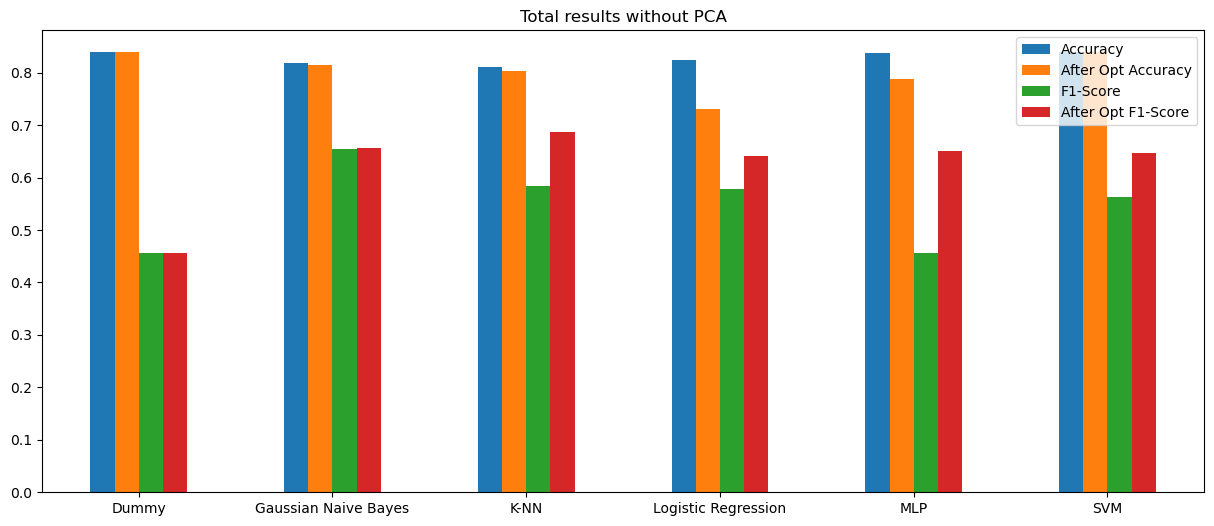

In [42]:
final_results_no_pca_df = pd.DataFrame(
    {'Accuracy': accuracy_lst, 'After Opt Accuracy': best_accuracy_no_pca_lst, 'F1-Score': f1_score_lst, 'After Opt F1-Score': best_f1_score_no_pca_lst}, index = classifier_names_lst
)

ax = final_results_no_pca_df.plot.bar(rot = 0, title = "Total results without PCA", figsize = (15, 6))

##### 5.2.2.3 Remarks

* We notice that the best performance based on the f1-score is the KNN Classifier with a value of f1-score = 0.687541 and accuracy = 0.802528. The preprocessing parameters that gave it the best performance are {'kNN__n_neighbors': 3, 'selector__threshold': 4.686611346127012} with a total time of 7.304515 seconds.

* The worst performance based on f1-score after the Dummy Classifier is Logistic Reghression with a value of f1-score = 0.641690 and accuracy = 0.729858. The preprocessing parameters that got it to this performance are {'lr__max_iter': 500, 'lr__solver': 'sag', 'selector__threshold': 0.10007357650134768} with a total time of 44.857403 seconds.

* We also notice that the Dummy Classifier has no improvement after preprocessing, which makes sense since it doesn't take samples into account at all.

* Apart from the dummy Classifier, all other Classifiers, after preprocessing, have significantly improved their performance.

##### 5.2.2.5 Confusion Matrix

<AxesSubplot:>

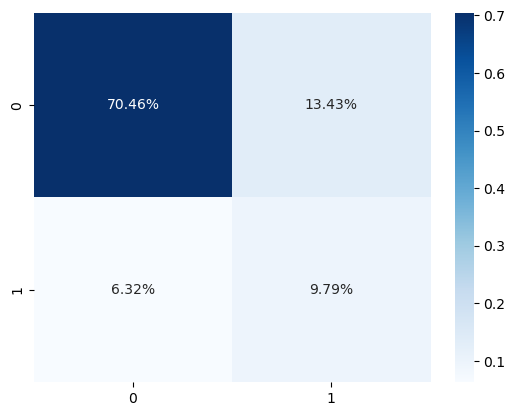

In [43]:
best_estimator_confusion_matrix = confusion_matrix(y_test_np, estimators_y_predictions_no_pca_dict["K-NN"])
sns.heatmap(best_estimator_confusion_matrix/np.sum(best_estimator_confusion_matrix), 
            annot = True, 
            fmt = '.2%', 
            cmap = 'Blues'
           )

<AxesSubplot:>

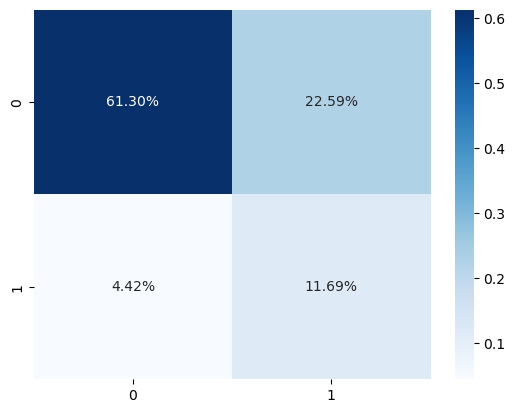

In [44]:
worst_estimator_confusion_matrix = confusion_matrix(y_test_np, estimators_y_predictions_no_pca_dict["Logistic Regression"])
sns.heatmap(worst_estimator_confusion_matrix/np.sum(worst_estimator_confusion_matrix), 
            annot = True, 
            fmt = '.2%', 
            cmap = 'Blues'
           )

**Using the PCA technique in the preprocessing part, Gaussian Naive Bayes Classifier had the best performance with f1-score = 0.691332 while when we did not use the PCA technique in the preprocessing part, K-NN had the best performance with f1- score = 0.687541. The performances of the classifiers are similar and comparing the performance of the other classifiers with and without PCA we could decide that its application to the specific problem could be omitted. Also, it is a given that the preprocessing process helped significantly to improve the performance of the classifiers, something we expected. According to all the above and with what we know about each classifier individually, we would recommend KNN as a classifier for this specific problem.**